# **Preparando ambiente**

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.1 MB/s eta 0:00:00a 0:00:01
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15781 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 20.94 MiB/s, done.
Resolving deltas: 100% (11537/11537), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't mat

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="mPBU1v94SGezxUf85k53")
project = rf.workspace("marcus-vinicius-kep9s").project("01000100yolo-redux")
version = project.version(1)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.5 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 01000100YOLO-Redux-1 in coco:: 100%|██████████| 5057/5057 [00:01<00:00, 4965.84it/s]


# **Verificando se o dataset está correto**

In [6]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, "/kaggle/working/01000100YOLO-Redux-1/train/_annotations.coco.json", "/kaggle/working/01000100YOLO-Redux-1/train")
register_coco_instances("my_dataset_val", {}, "/kaggle/working/01000100YOLO-Redux-1/valid/_annotations.coco.json", "/kaggle/working/01000100YOLO-Redux-1/valid")
register_coco_instances("my_dataset_test", {}, "/kaggle/working/01000100YOLO-Redux-1/test/_annotations.coco.json", "/kaggle/working/01000100YOLO-Redux-1/test")

WARNING [03/18 17:01:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/18 17:01:33 d2.data.datasets.coco]: Loaded 3529 images in COCO format from /kaggle/working/01000100YOLO-Redux-1/train/_annotations.coco.json


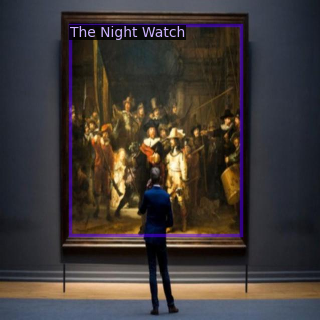

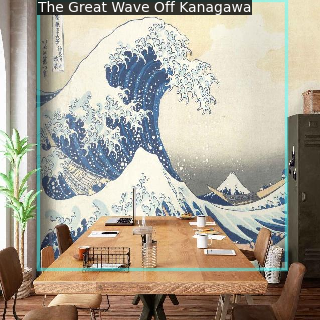

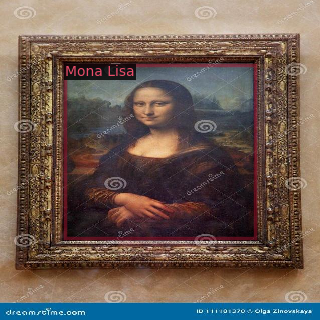

In [7]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
import os
import numpy as np
import torch
import time
import datetime
import logging
from detectron2.engine import HookBase, DefaultTrainer
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm
from detectron2.config import get_cfg
from detectron2 import model_zoo

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
        
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    f"Loss on Validation done {idx + 1}/{total}. {seconds_per_img:.4f} s / img. ETA={eta}",
                    n=5,
                )
            
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()
    
    def _get_loss(self, data):
        metrics_dict = self._model(data)
        metrics_dict = {k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v) for k, v in metrics_dict.items()}
        return sum(metrics_dict.values())
    
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
    def build_hooks(self):
        hooks = super().build_hooks()
        if len(self.cfg.DATASETS.VAL) > 0:  # Garante que haja um dataset de validação
            hooks.insert(-1, LossEvalHook(
                self.cfg.TEST.EVAL_PERIOD,
                self.model,
                build_detection_test_loader(
                    self.cfg,
                    self.cfg.DATASETS.VAL[0],
                    DatasetMapper(self.cfg, True)
                )
            ))
        return hooks

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.VAL = ("my_dataset_val",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
# Parte do Retinanet
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5  # Teste com valores entre 0.4 e 0.6
cfg.MODEL.RETINANET.NMS_THRESH = 0.3  # Teste com valores entre 0.3 e 0.5
# Acaba aqui
cfg.TEST.EVAL_PERIOD = 100
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/18 17:01:48 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_5bd44e.pkl: 152MB [00:02, 73.7MB/s]                              


[03/18 17:01:50 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


[03/18 17:02:23 d2.utils.events]:  eta: 0:47:25  iter: 19  total_loss: 1.612  loss_cls: 1.265  loss_box_reg: 0.3866    time: 1.4544  last_time: 1.4623  data_time: 0.0610  last_data_time: 0.0628   lr: 0.00019981  max_mem: 8148M
[03/18 17:03:10 d2.utils.events]:  eta: 0:47:25  iter: 39  total_loss: 0.6976  loss_cls: 0.4875  loss_box_reg: 0.222    time: 1.4461  last_time: 1.3309  data_time: 0.0532  last_data_time: 0.0704   lr: 0.00039961  max_mem: 8148M
[03/18 17:03:39 d2.utils.events]:  eta: 0:47:13  iter: 59  total_loss: 0.4972  loss_cls: 0.3469  loss_box_reg: 0.1567    time: 1.4505  last_time: 1.5355  data_time: 0.0488  last_data_time: 0.0473   lr: 0.00059941  max_mem: 8148M


# **Resultados**

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
#register_coco_instances("my_dataset_test", {}, "/kaggle/working/01000100YOLO-5/test/_annotations.coco.json", "/kaggle/working/01000100YOLO-5/test")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob
import random

N = 10  # Número de imagens desejadas
image_paths = random.sample(glob.glob('/kaggle/working/01000100YOLO-Redux-1/test/*jpg'), N)

for imageName in image_paths:
    im = cv2.imread(imageName)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.8
                  )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


# **Validação**

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

# **Baixar Modelo Treinado**

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/arquivo", 'zip', "/kaggle/working/output")

#from google.colab import files
#files.download("/kaggle/working/outputarquivo.zip")